In [346]:
import collections
from wilcoxon import sheets
import re
from shapely.geometry import Point, LineString
import geopandas as gpd
import pandas as pd
import geoplot
import contextily as ctx
from shapely import wkt
import numpy as np
import math

%matplotlib inline

import matplotlib.pyplot as plt

JE = "Jurong East"
CCK = "Choa Chu Kang"
BP = "Bukit Panjang"
BG = "Botanic Gardens"
BI = "Bishan"
SR = "Serangoon"
SK = "Sengkang"
PG = "Punggol"
TP = "Tampines"
EX = "Expo"
TM = "Tanah Merah"
PL = "Paya Lebar"
BU = "Bugis"
PR = "Promenade"
BF = "Bayfront"
MB = "Marina Bay"
RP = "Raffles Place"
CH = "City Hall"
DG = "Dhoby Ghaut"
CT = "Chinatown"
OP = "Outram Park"
HF = "HarbourFront"
BV = "Buona Vista"
NT = "Newton"
LI = "Little India"
MP = "MacPherson"
WD = "Woodlands"
BH = "Bright Hill"
CC = "Caldecott"
ST = "Stevens"
OC = "Orchard"
SB = "Sungei Bedok"
PA = "Pasir Ris"
HG = "Hougang"
AMK = "Ang Mo Kio"
TG = "Tengah"
BJ = "Bahar Junction"
BL = "Boon Lay"

NSL = "NSL" 
EWL = "EWL" 
NEL = "NEL" 
CCL = "CCL" 
DTL = "DTL" 
LRT = "LRT"
TEL = "TEL"
CRL = "CRL"
JRL = "JRL"
# L = [CCK,BP,LRT,
#     JE,CCK,NSL,
#     CCK,WD,NSL,
#     WD,AMK,NSL,
#     AMK,BI,NSL,
#     BI,NT,NSL,
#     NT,OC,NSL,
#     OC,DG,NSL,
#     DG,CH,NSL,
#     CH,RP,NSL,
#     RP,MB,NSL,
#     BP,BG,DTL,
#     BG,ST,DTL,
#     ST,NT,DTL,
#     NT,LI,DTL,
#     LI,BU,DTL,
#     BU,PR,DTL,
#     PR,BF,DTL,
#     BF,CT,DTL,
#     CT,MP,DTL,
#     MP,TP,DTL,
#     TP,EX,DTL,
#     EX,SB,DTL,
#     PA,TP,EWL,
#     TP,TM,EWL,
#     TM,EX,EWL,
#     TM,PL,EWL,
#     PL,BU,EWL,
#     BU,CH,EWL,
#     CH,RP,EWL,
#     RP,OP,EWL,
#     OP,BV,EWL,
#     BV,JE,EWL,
#     JE,BL,EWL,
#     HF,OP,NEL,
#     OP,CT,NEL,
#     CT,DG,NEL,
#     DG,LI,NEL,
#     LI,SR,NEL,
#     SR,HG,NEL,
#     HG,SK,NEL,
#     SK,PG,NEL,
#     HF,BV,CCL,
#     BV,BG,CCL,
#     BG,CC,CCL,
#     CC,BI,CCL,
#     BI,SR,CCL,
#     SR,MP,CCL,
#     MP,PL,CCL,
#     PL,PR,CCL,
#     PR,BF,CCL,
#     BF,MB,CCL,
#     MB,HF,CCL,
#     PR,DG,CCL,
#     WD,BH,TEL,
#     BH,CC,TEL,
#     CC,ST,TEL,
#     ST,OC,TEL,
#     OC,OP,TEL,
#     OP,MB,TEL,
#     MB,SB,TEL,
#     PA,HG,CRL,
#     HG,AMK,CRL,
#     AMK,BH,CRL,
#     BL,BJ,JRL,
#     BJ,TG,JRL,
#     TG,CCK,JRL,
#     JE,TG,JRL]

L = [JE,CCK,NSL,
    CCK,BP,LRT,
    CCK,BI,NSL,
    BI,NT,NSL,
    NT,DG,NSL,
    DG,CH,NSL,
    CH,RP,NSL,
    RP,MB,NSL,
    BP,BG,DTL,
    BG,NT,DTL,
    NT,LI,DTL,
    LI,BU,DTL,
    BU,PR,DTL,
    PR,BF,DTL,
    BF,CT,DTL,
    CT,MP,DTL,
    MP,TP,DTL,
    TP,EX,DTL,
    TP,TM,EWL,
    TM,EX,EWL,
    TM,PL,EWL,
    PL,BU,EWL,
    BU,CH,EWL,
    CH,RP,EWL,
    RP,OP,EWL,
    OP,BV,EWL,
    BV,JE,EWL,
    HF,OP,NEL,
    OP,CT,NEL,
    CT,DG,NEL,
    DG,LI,NEL,
    LI,SR,NEL,
    SR,SK,NEL,
    SK,PG,NEL,
    HF,BV,CCL,
    BV,BG,CCL,
    BG,BI,CCL,
    BI,SR,CCL,
    SR,MP,CCL,
    MP,PL,CCL,
    PL,PR,CCL,
    PR,BF,CCL,
    BF,MB,CCL,
    PR,DG,CCL]

L = [(L[3*i:3*i+3]) for i in range(int(len(L)/3))]
stations = list(set([item for sublist in [[x[0],x[1]] for x in L] for item in sublist]))


In [40]:
# LTEL = [x for x in L if not any(item in x for item in ["JRL","CRL","Pasir Ris","Boon Lay"])]
# stationsTEL = list(set([item for sublist in [[x[0],x[1]] for x in LTEL] for item in sublist]))

In [66]:
def paths(l, s, start, counter):
    counter += 1
    if len(l) == 0 or len(s) == 0:
        return [[start]]
    else:
        possible = [x for x in l if start in x]
        ignoreStation = [[y for y in x if y != start] for x in possible]
        newConnections = [x for x in l if x not in possible]
        newStations = [x for x in s if x != start]
        # if len(newStations) == 1:
        #     print(start)
        if len(ignoreStation) == 0:
            return [[start]]
        else:
            options = []
            for chosen in ignoreStation:
                options.extend([[start,chosen[1]] + x for x in paths(newConnections, newStations, chosen[0], counter + 1)])
            return options

res = paths(L, stations, PG, 0)

In [67]:
reachesAll = [x for x in res if len(x) == 2*len(stations) - 1]
# reachesAllTEL = [x for x in res if len(x) == 2*len(stationsTEL) - 1]

In [68]:
len(reachesAll)

634

In [137]:
solutions = []
for potentialSolution in reachesAll:    
    stationsOrder = [potentialSolution[2*i] for i in range(len(stations))]
    linesOrder = [potentialSolution[2*i+1] for i in range(len(stations)-1)]
    condensedLinesOrder = [linesOrder[i] for i in range(len(linesOrder)-1) if linesOrder[i] != linesOrder[i+1]] + [linesOrder[-1]]
    usages = [x for x in collections.Counter(condensedLinesOrder).most_common() if x[0] != "LRT"]
    # success = collections.Counter(condensedLinesOrder)["DTL"] < 2
    # success = usages[0][1] > 4 #and usages[-1][1] == 2
    # success = usages[1][1] > 4 #and usages[-1][1] == 2
    # success = sum(collections.Counter(condensedLinesOrder).values()) == 11
    success = True
    if success: solutions.append(list(zip(stationsOrder, linesOrder+["END"])))
        
# solutionsTEL = []
# for potentialSolution in reachesAllTEL:    
#     stationsOrder = [potentialSolution[2*i] for i in range(len(stationsTEL))]
#     linesOrder = [potentialSolution[2*i+1] for i in range(len(stationsTEL)-1)]
#     condensedLinesOrder = [linesOrder[i] for i in range(len(linesOrder)-1) if linesOrder[i] != linesOrder[i+1]] + [linesOrder[-1]]
#     usages = [x for x in collections.Counter(condensedLinesOrder).most_common() if x[0] != "LRT"]
#     success = usages[0][1] == 3 and usages[-1][1] != 3
#     if success: solutionsTEL.append(list(zip(stationsOrder, linesOrder+["END"])))

noLRT = [z[0] for z in list(zip(solutions, ["LRT" in [y[1] for y in x] for x in solutions])) if not z[1]]

solutionList = []
for x in solutions:
    m=[]
    for y in x:
        m+=list(y)
    solutionList.append(m)

# collections.Counter([item for sublist in solutions for item in sublist]).most_common()
        

In [234]:
mrt = sheets.getGeo("MRT")

In [241]:
nameIndex = mrt.set_index("Name").to_dict("index")
mrt["Label List"] = mrt.Label.str.split(", ")
mrt = mrt.explode("Label List")
mrt.drop_duplicates(inplace=True, subset=["Label List"])
labelIndex = mrt.set_index("Label List").to_dict("index")

nameIndex["Tanah Merah"]["Label"] = "EW4, CG0"
nameIndex["Promenade"]["Label"] = "CC4, DT15, CE0"

In [348]:
G = []
for solution in solutions:

    currentLabels = []
    for i in range(len(solution)-1):
        connection = solution[i] + (solution[i+1][0],)
    #     print(connection)
        lineAbbr = connection[1][:-1]
        if lineAbbr == "LR": lineAbbr = "BP"
        if "Expo" in connection and lineAbbr == "EW": lineAbbr = "CG"
        if "Bayfront" in connection and ("Promenade" in connection or "Marina Bay" in connection) and lineAbbr == "CC": lineAbbr = "CE"
    #     print(lineAbbr)
        startLabel = int(re.compile(f"{lineAbbr}\d+").search(nameIndex[connection[0]]["Label"]).group()[2:])
        endLabel = int(re.compile(f"{lineAbbr}\d+").search(nameIndex[connection[2]]["Label"]).group()[2:])
        betweenNumbers = [i for i in range(min(startLabel, endLabel), max(startLabel, endLabel) + 1)]
        if betweenNumbers[0] != startLabel:
            betweenNumbers.reverse()
        betweenLabels = [lineAbbr + str(x) for x in betweenNumbers]
        if i == 0: currentLabels.extend(betweenLabels)
        else: currentLabels.extend(betweenLabels[1:])

    filteredLabels = [x for x in currentLabels if not any([x in item for item in ["NE2"]])]
    mappedLabels = "||".join(filteredLabels).replace("CG0","EW4").replace("CE0","CC4").split("||")
    mappedLabels = [x for x in mappedLabels if not math.isnan(labelIndex[x]["Lat"])]

    G.append([", ".join([labelIndex[x]["Name"] for x in mappedLabels]), LineString([Point(labelIndex[x]["Long"], labelIndex[x]["Lat"]) for x in mappedLabels])])

In [349]:
G = gpd.GeoDataFrame(pd.DataFrame(G, columns = ["Path", "geometry"]), geometry="geometry")

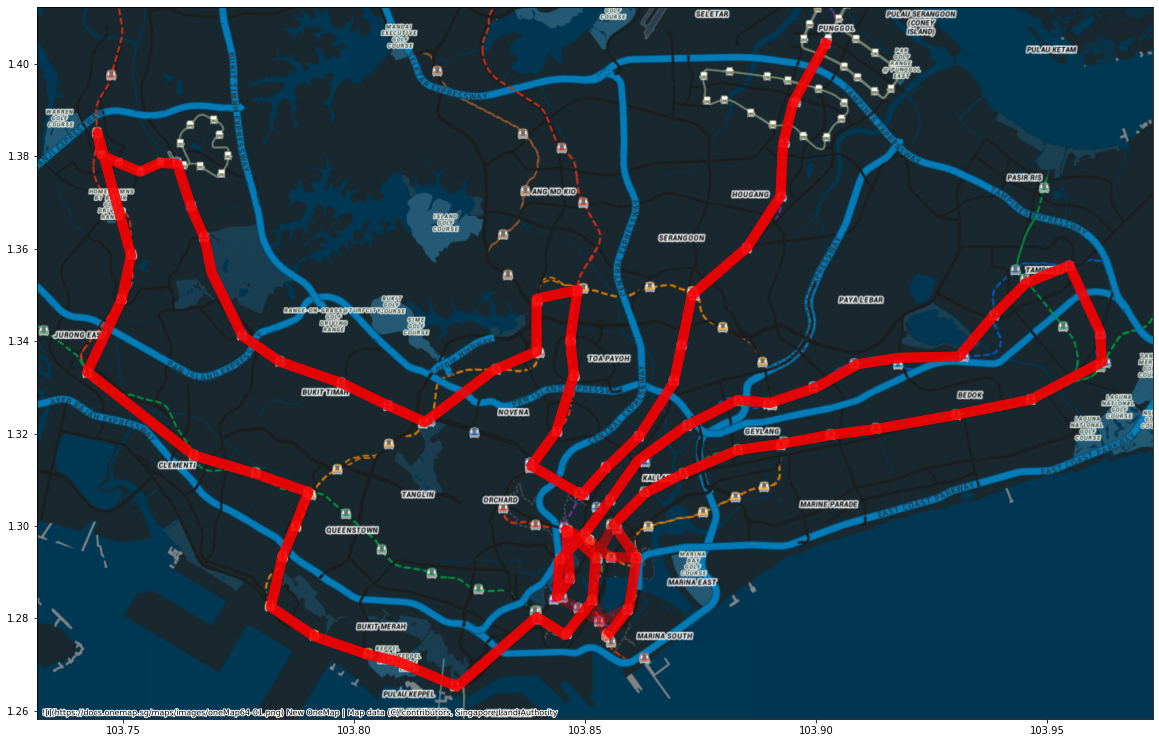

In [353]:
ax = G.geometry.iloc[:6].plot(figsize=(20,20), edgecolor="red", linewidth=10, alpha = 0.3)
ctx.add_basemap(ax, zoom=13, crs="EPSG:4326", source=ctx.providers.OneMapSG.Night)

In [345]:
labelIndex["NS6"]["Lat"] == float("nan")

False

In [248]:
mrt["Label List"]

0       CR2
1       CG2
2       CR3
3      DT36
4       CG1
       ... 
220    EW32
221    EW33
222     JS2
223     NS6
223      DT
Name: Label List, Length: 271, dtype: object

In [240]:
mrt["Label List"].unique()

array(['CR2', 'CG2', 'CR3', 'DT36', 'CG1', 'DT34', 'CR4', 'DT37', 'DT33',
       'EW3', 'EW1', 'TE30', 'EW4', 'EW2', 'TE29', 'DT31', 'CP2', 'CR6',
       'DT30', 'EW5', 'TE28', 'DT29', 'PE4', 'PE5', 'NE18', 'TE27', 'EW6',
       'PE6', 'PE3', 'DT28', 'PE7', 'PE2', 'PW3', 'SE2', 'PW2', 'PE1',
       'SE3', 'TE26', 'PW1', 'EW7', 'NE17', 'SE4', 'PW4', 'SE1', 'PW5',
       'DT27', 'CR7', 'PW6', 'TE25', 'SE5', 'PW7', 'NE16', 'SW1', 'NE15',
       'EW8', 'NE14', 'SW8', 'CC10', 'SW2', 'CC8', 'CC11', 'SW7', 'TE24',
       'NE13', 'EW9', 'DT25', 'CC7', 'SW3', 'SW6', 'CC12', 'SW5', 'CC6',
       'SW4', 'CR9', 'TE23', 'NE12', 'EW10', 'DT24', 'NE11', 'NE10',
       'TE22A', 'TE22', 'CC14', 'CC5', 'CR10', 'NS28', 'TE21', 'EW11',
       'NE9', 'DT23', 'CC4', 'CE1', 'EW12', 'DT22', 'CC3', 'NS27', 'NE8',
       'DT17', 'DT13', 'NS25', 'NS26', 'TE19', 'CC2', 'DT21', 'NS16',
       'NE7', 'NS17', 'DT18', 'NS19', 'CC32', 'NS18', 'NE5', 'NS24',
       'EW15', 'NS15', 'DT20', 'NE4', 'TE18', 'NS20', 'CR12',

In [251]:
M = ["a","b","c"]
M.replace("a","t")

AttributeError: 'list' object has no attribute 'replace'

In [265]:
shapely.geometry.Point(1,2)

AttributeError: module 'shapely' has no attribute 'geometry'